In [382]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import keras

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix

In [383]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [384]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


In [385]:
# Number of converations in the dataset: 223606

The dataset has many different features, we are only using act_tag and text for this training.


In [386]:
reduced_df = result[['act_tag','text']]


Reduce down the number of tags to 43 - converting the combined tags to their generic classes:

In [387]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [388]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

<ipython-input-388-3a505b615f58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))


There are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


To get unique tags:

In [389]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [390]:
unique_tags

{'%',
 '+',
 '^2',
 '^g',
 '^h',
 '^q',
 'aa',
 'aap_am',
 'ad',
 'ar',
 'arp_nd',
 'b',
 'b^m',
 'ba',
 'bd',
 'bf',
 'bh',
 'bk',
 'br',
 'fa',
 'fc',
 'fo_o_fw_"_by_bc',
 'fp',
 'ft',
 'h',
 'na',
 'ng',
 'nn',
 'no',
 'ny',
 'oo_co_cc',
 'qh',
 'qo',
 'qrr',
 'qw',
 'qw^d',
 'qy',
 'qy^d',
 'sd',
 'sv',
 't1',
 't3',
 'x'}

In [391]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [392]:
#one_hot_encoding_dic["br"]

In [393]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create utterance representations as sequences of words:

In [394]:
utterances = []
for i in range(0, len(reduced_df)):
    utterances.append(reduced_df['text'].iloc[i].split(" "))


In [395]:
wordvectors = {}
index = 1
for u in utterances:
    for w in u:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [396]:
# Max length of 137
MAX_LENGTH = len(max(utterances, key=len))

In [397]:
MAX_LENGTH

137

In [398]:
utterance_embeddings = []
for u in utterances:
    utterance_emb = []
    for w in u:
        utterance_emb.append(wordvectors[w])
    utterance_embeddings.append(utterance_emb)


Then we split the dataset into test and train.

In [399]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(utterance_embeddings, np.array(tags_encoding))


And pad the utterances with zero to make all utterances of equal length.


In [400]:
MAX_LENGTH = 137

In [401]:
from keras.preprocessing.sequence import pad_sequences
 
train_utterances_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_utterances_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

In [402]:
train_input = train_utterances_X[:140000]
val_input = train_utterances_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


# Model 1 - BILSTM

The first approach we'll try is to treat DA tagging as a standard multi-class text classification task, in the way you've done before with sentiment analysis and other tasks. Each utterance will be treated independently as a text to be classified with its DA tag label. This model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

In [403]:
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(utterances, key=len)) #137
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) #43

In [404]:
from keras.models import Sequential, Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input,Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam

#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states

# Embedding layer
# Bidirectional 1
# Bidirectional 2
# Dense layer
# Activation

Input = Input(shape=(MAX_LENGTH,),dtype='int32')
Embedding = Embedding(VOCAB_SIZE+1, EMBED_SIZE, input_length=MAX_LENGTH, mask_zero=True)(Input)
Bidirectional_1 = Bidirectional(LSTM(HIDDEN_SIZE,return_sequences = True))(Embedding)
Bidirectional_2 = Bidirectional(LSTM(HIDDEN_SIZE,return_sequences = False))(Bidirectional_1)
Dense = Dense(HIDDEN_SIZE)(Bidirectional_2)
Activation = Activation("softmax")(Dense)
model = Model(inputs=[Input], outputs=[Activation])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 137)]             0         
_________________________________________________________________
embedding_64 (Embedding)     (None, 137, 100)          4373200   
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 86)                44720     
_________________________________________________________________
dense_43 (Dense)             (None, 43)                3741      
_________________________________________________________________
activation_8 (Activation)    (None, 43)                0         
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
________________________________________________

In [405]:
# WARNING:tensorflow:From /Users/mortro/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
# Instructions for updating:
# Colocations handled automatically by placer.
# Model: "sequential_1"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding_1 (Embedding)      (None, 137, 100)          4371500   
# _________________________________________________________________
# bidirectional_1 (Bidirection (None, 137, 86)           49536     
# _________________________________________________________________
# bidirectional_2 (Bidirection (None, 86)                44720     
# _________________________________________________________________
# dense_1 (Dense)              (None, 43)                3741      
# _________________________________________________________________
# activation_1 (Activation)    (None, 43)                0         
# =================================================================
# Total params: 4,469,497
# Trainable params: 4,469,497
# Non-trainable params: 0

In [406]:
train_input = train_utterances_X[:140000]
val_input = train_utterances_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]
print(len(train_input))
print(len(val_input))
print(len(train_labels))
print(len(val_labels))

140000
27704
140000
27704


In [407]:
# Train the model - using validation 

Training = model.fit(train_input,
                    train_labels,
                    epochs=3,
                    batch_size=512,
                    validation_data=(val_input, val_labels),
                    verbose=1)

Epoch 1/3
274/274 [==============================] - 1252s 5s/step - loss: 2.2923 - accuracy: 0.4454 - val_loss: 1.1967 - val_accuracy: 0.6562
Epoch 2/3
274/274 [==============================] - 1533s 6s/step - loss: 1.1186 - accuracy: 0.6795 - val_loss: 1.0300 - val_accuracy: 0.6952
Epoch 3/3
274/274 [==============================] - 1556s 6s/step - loss: 0.9411 - accuracy: 0.7265 - val_loss: 0.9895 - val_accuracy: 0.7029


In [408]:
# WARNING:tensorflow:From /Users/mortro/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
# Instructions for updating:
# Use tf.cast instead.
# Train on 140000 samples, validate on 27704 samples
# Epoch 1/3

In [409]:
score = model.evaluate(test_utterances_X, y_test, batch_size=100)

560/560 [==============================] - 85s 152ms/step - loss: 1.0053 - accuracy: 0.7009


In [410]:
print("Overall Accuracy:", score[1]*100)


Overall Accuracy: 70.09051442146301


## Evaluation


The overall accuracy is 67%, an effective accuracy for this task.

In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？

## Minority Classes

In [411]:
# Generate predictions for the test data
predicted = model.predict(test_utterances_X,batch_size=100)
pred_y_classes = predicted.argmax(axis=-1)
pred_y_classes

array([23, 39, 23, ..., 39, 26, 23], dtype=int64)

In [412]:
y_test_classes = np.argmax(y_test, axis=1)
y_test_classes

array([10,  8, 23, ..., 26, 26, 23], dtype=int64)

In [413]:
cm = confusion_matrix(y_test_classes, pred_y_classes)

In [414]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):

    ax = plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title("Dialogue Act Confussion Matrix")
    plt.colorbar()
    #tick_marks = np.arange(len(df_confusion.columns))
    #plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    #plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel("Groung Truth")
    plt.xlabel("Predicted")




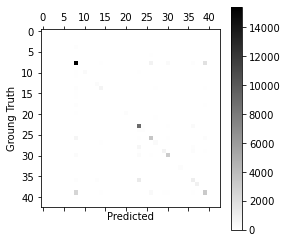

In [415]:
mat = plot_confusion_matrix(cm)
mat

In [416]:
# Calculate Accuracies for "br" = 18 and "bf"= 15
from sklearn.metrics import confusion_matrix 

mat = confusion_matrix(y_test_classes, pred_y_classes) 
classes_accuracy = mat.diagonal()/mat.sum(axis=1)   #Calculates the accuracy of each individual classes


bf_acc = classes_accuracy[15]   #bf class at index 15
print("br accuracy:", bf_acc)

br_acc = classes_accuracy[18]   #br class at index 18
print("br accuracy:", br_acc)

br accuracy: 0.0
br accuracy: 0.0



Due to the reduced lack of training data for the minority classes, these minority classifiers will not be very confident in classification, as they have not been fully optimised. The frequent classifiers will be more optimised and will generate more confident scores for all examples, effectively crowding out the less confident minority classifiers. 




# Model 2 - Balanced Network


One thing we can do to try to improve performance is therefore to balance the data more sensibly. As the dataset is highly imbalanced, we can simply weight the loss function in training, to weight up the minority classes proportionally to their underrepresentation. 

In [188]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

C:\Users\FiercePC\anaconda3a\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42], y=[11 27 18 ...  8 39 39] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [191]:
d_class_weights

{0: 50.48679160081282,
 1: 50.00134168157424,
 2: 24.762569213732004,
 3: 44.44563705028821,
 4: 5.273975187508845,
 5: 17.16217668278456,
 6: 7.123478814909206,
 7: 15.072868217054264,
 8: 0.06896462388610163,
 9: 18.182306066026996,
 10: 2.011659394539157,
 11: 4.2554333346020625,
 12: 25.121447028423773,
 13: 3.7736861646471125,
 14: 1.0924662888411178,
 15: 6.915079168728353,
 16: 6.1106222501571335,
 17: 47.273995771670194,
 18: 4.272916626855975,
 19: 49.52513842746401,
 20: 4.23809253046758,
 21: 7.914976461010229,
 22: 8.996781202220971,
 23: 0.13548733839357288,
 24: 3.972604686694974,
 25: 55.91547886971743,
 26: 0.27821622892749026,
 27: 2.613135444665186,
 28: 1.7105722154222767,
 29: 1.0840399280558102,
 30: 0.33159925614613706,
 31: 9.33597762097616,
 32: 17.391771019677996,
 33: 4.91971573782755,
 34: 65.00174418604651,
 35: 65.82455107447748,
 36: 0.4660876162842808,
 37: 1.4138497919749105,
 38: 66.66845557543232,
 39: 0.19603194989571837,
 40: 5.411175374488783,
 41: 

## Define & Train the model

In [301]:
# Re-built the model for the balanced training

from keras.models import Sequential, Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input,Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam


Input = Input(shape=(MAX_LENGTH,),dtype='int32')
Embedding = Embedding(VOCAB_SIZE+1, EMBED_SIZE, input_length=MAX_LENGTH, mask_zero=True)(Input)
Bidirectional_1 = Bidirectional(LSTM(HIDDEN_SIZE,return_sequences = True))(Embedding)
Bidirectional_2 = Bidirectional(LSTM(HIDDEN_SIZE,return_sequences = False))(Bidirectional_1)
Dense = Dense(HIDDEN_SIZE)(Bidirectional_2)
Activation = Activation("softmax")(Dense)
model2 = Model(inputs=[Input], outputs=[Activation])

model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.summary()


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 137)]             0         
_________________________________________________________________
embedding_49 (Embedding)     (None, 137, 100)          4373200   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 86)                44720     
_________________________________________________________________
dense_22 (Dense)             (None, 43)                3741      
_________________________________________________________________
activation_6 (Activation)    (None, 43)                0         
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
________________________________________________

In [193]:
# Train the balanced network -  takes  time to achieve good accuracy
Training = model2.fit(train_input,
                    train_labels,
                    epochs=3,
                    batch_size=512,
                    validation_data=(val_input, val_labels),
                    verbose=1,class_weight=d_class_weights)

Epoch 1/3
274/274 [==============================] - 788s 3s/step - loss: 3.4769 - accuracy: 0.1829 - val_loss: 2.2969 - val_accuracy: 0.3370
Epoch 2/3
274/274 [==============================] - 963s 4s/step - loss: 2.2051 - accuracy: 0.3671 - val_loss: 2.0520 - val_accuracy: 0.3942
Epoch 3/3
274/274 [==============================] - 1036s 4s/step - loss: 1.6970 - accuracy: 0.4330 - val_loss: 2.0157 - val_accuracy: 0.4125


## Test the model

In [194]:
# Overall Accuracy
score = model2.evaluate(test_utterances_X, y_test, batch_size=100)

560/560 [==============================] - 67s 120ms/step - loss: 2.0077 - accuracy: 0.4171


In [195]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 41.710492968559265


In [196]:
# Generate predictions for the test data
label_pred = model2.predict(test_utterances_X, batch_size=100)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

br accuracy: 28.723404255319153
br accuracy: 3.4013605442176873


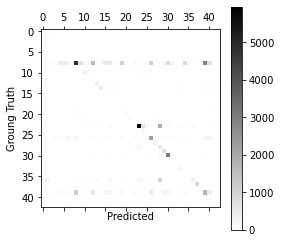

In [205]:
# Build the confusion matrix off these predictions

matrix_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))

mat = plot_confusion_matrix(matrix_balanced)
mat

# Calculate Accuracies for "br" and "bf"

mat = confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1)) 
classes_accuracy = mat.diagonal()/mat.sum(axis=1)   #Calculates the accuracy of each individual classes


bf_acc = classes_accuracy[15]   #bf class at index 15
print("bf accuracy:", bf_acc*100)

br_acc = classes_accuracy[18]   #br class at index 18
print("br accuracy:", br_acc*100)

# Using Context for Dialog Act Classification

The second approach we will try is a hierarchical approach to DA tagging. We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the utterance CNN representation. The CNN model learns textual information in each utterance for DA classification, acting like the text classifier from Model 1 above. Then we use a bidirectional-LSTM (BLSTM) above that to learn how to use the context before and after the current utterance to improve the output.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output



## CNN


This is a classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes. 

In [422]:
from keras.models import Sequential, Model
from keras.layers import LSTM
from keras.layers import Dense,Flatten
from keras.layers import Dense, Reshape,BatchNormalization,MaxPool2D
from keras.layers import Input,Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding,Conv2D
from keras.optimizers import Adam

filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(utterances, key=len)) #137
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
Input_1 = Input(shape=(MAX_LENGTH,),dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(Input_1)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)

conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)

conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)


# concatenate tensors
concat_tensors = Concatenate()([maxpool_0,maxpool_1,maxpool_2])
#time_distributed = TimeDistributed(concat_tensors)

# flatten concatenated tensors

flattened_tensor=TimeDistributed(Flatten())(concat_tensors)
#flattened_tensor = Flatten()(concat_tensors)

# dense layer (dense_1)
dense_1 = Dense(HIDDEN_SIZE)(flattened_tensor)
print(Dense_1.shape)


# dropout_1
dropout_1 = Dropout(drop)(dense_1)
print(dropout_1.shape)


(None, 1, 43)
(None, 1, 43)


If you want CNN layers to interact with the LSTM layer, they need to be distributed across time.

## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM. Try the output of cnn as the input for blstm.

In [423]:
# BLSTM model
from keras.models import Sequential, Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input,Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam


#dropout_1 = Flatten()(dropout_1)
#Input_2 = Input(shape=(MAX_LENGTH,),dtype='int32')
#Embedding = Embedding(VOCAB_SIZE+1, EMBED_SIZE, input_length=MAX_LENGTH, mask_zero=True)(dropout_1)
# Bidirectional 1
Bidirectional_1 = Bidirectional(LSTM(HIDDEN_SIZE,return_sequences = True))(dropout_1)
# Bidirectional 2
Bidirectional_2 = Bidirectional(LSTM(HIDDEN_SIZE,return_sequences = False))(Bidirectional_1)
# Dense layer (dense_2)
dense_2 = Dense(HIDDEN_SIZE)(Bidirectional_2)
# dropout_2
dropout_2 = Dropout(drop)(dense_2)


Concatenate 2 last layers and create the output layer. You need to concatenate the outputs of CNN and LSTM (dropout_1 and dropout_2)

In [424]:
# concatenate 2 final layers
dropout_1flat = Flatten()(dropout_1)

final_concat_output = Concatenate()([dropout_1flat,dropout_2])
model_output = Dense(HIDDEN_SIZE)(final_concat_output)
Activation = Activation("softmax")(model_output)
print(model_output.shape)

(None, 43)


In [430]:
# output
model3 = Model(inputs=[Input_1], outputs=[Activation])
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model3.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 137)]        0                                            
__________________________________________________________________________________________________
embedding_65 (Embedding)        (None, 137, 100)     4373200     input_61[0][0]                   
__________________________________________________________________________________________________
reshape_45 (Reshape)            (None, 137, 100, 1)  0           embedding_65[0][0]               
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 135, 1, 64)   19264       reshape_45[0][0]                 
___________________________________________________________________________________________

In [426]:
# Train the model - using validation 

Training = model3.fit(train_input,
                    train_labels,
                    epochs=3,
                    batch_size=512,
                    validation_data=(val_input, val_labels),
                    verbose=1)

Epoch 1/3
274/274 [==============================] - 158s 555ms/step - loss: 0.1411 - accuracy: 0.4169 - val_loss: 0.1324 - val_accuracy: 0.6473
Epoch 2/3
274/274 [==============================] - 140s 512ms/step - loss: 0.0359 - accuracy: 0.7200 - val_loss: 0.0412 - val_accuracy: 0.6931
Epoch 3/3
274/274 [==============================] - 141s 514ms/step - loss: 0.0278 - accuracy: 0.7838 - val_loss: 0.0363 - val_accuracy: 0.7016


In [427]:
score = model3.evaluate(test_utterances_X, y_test, batch_size=100)

560/560 [==============================] - 10s 18ms/step - loss: 0.0367 - accuracy: 0.7035


In [428]:
print("Overall Accuracy:", score[1]*100)

#Predicted labels
label_pred = model3.predict(test_utterances_X, batch_size=100)

Overall Accuracy: 70.35168409347534


bf accuracy: 16.577540106951872
br accuracy: 2.3529411764705883


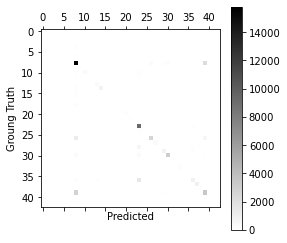

In [429]:
matrix_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))

mat = plot_confusion_matrix(matrix_balanced)
mat

# Calculate Accuracies for "br" and "bf"

mat = confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1)) 
classes_accuracy = mat.diagonal()/mat.sum(axis=1)   #Calculates the accuracy of each individual classes


bf_acc = classes_accuracy[15]   #bf class at index 15
print("bf accuracy:", bf_acc*100)

br_acc = classes_accuracy[18]   #br class at index 18
print("br accuracy:", br_acc*100)